# Real-time Audio Processing Testing Notebook

This notebook demonstrates and tests the audio processing system with faster-whisper integration.

### Install dependencies

In [2]:
!apt-get update && apt-get install -y portaudio19-dev python3-pyaudio

!brew install portaudio

# Install required packages
!pip install faster-whisper webrtcvad numpy websockets torch matplotlib sounddevice scipy pyaudio gtts pydub soundfile librosa tqdm 'realtimetts[coqui]'

zsh:1: command not found: apt-get
==> Downloading https://formulae.brew.sh/api/formula.jws.json
######################################################################### 100.0%
==> Downloading https://formulae.brew.sh/api/cask.jws.json
######################################################################### 100.0%
To reinstall 19.7.0, run:
  brew reinstall portaudio


In [3]:
import base64
import numpy as np
from collections import deque
from typing import Optional, List, Dict, Union, Tuple
import webrtcvad
import wave
import json
from gtts import gTTS
import torch
from faster_whisper import WhisperModel
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import asyncio
import websockets
import queue
import threading
import time
from gtts import gTTS
from pydub import AudioSegment
import io
import sounddevice as sd
import webrtcvad
from collections import deque
import logging
from datetime import datetime
import threading
import soundfile as sf
from tqdm.notebook import tqdm

# different plot style
plt.style.use('dark_background')

### Record human real audio

In [ ]:
def record_audio(duration_seconds: float = 5.0, sample_rate: int = 16000, channels: int = 1) -> np.ndarray:
    """
    Record audio for the specified duration and return the audio data as a NumPy array.
    
    Args:
        duration_seconds: Duration of the audio recording in seconds.
        sample_rate: Sample rate of the audio recording in Hz.
        channels: Number of audio channels (1 for mono, 2 for stereo).
        
    Returns:
        Audio data as a NumPy array.
    """
    # Record audio
    print(f"Recording audio for {duration_seconds} seconds...")
    start_time = time.time()
    audio = sd.rec(int(duration_seconds * sample_rate), samplerate=sample_rate, channels=channels)
    
    while time.time() - start_time < duration_seconds:
        elapsed_time = time.time() - start_time
        progress = elapsed_time / duration_seconds * 100
        print(f"Recording progress: {progress:.2f}%", end="\r")
        time.sleep(0.1)
    
    print("Recording complete.")
    sd.wait()  # Wait for the recording to finish
    
    return audio

test_audio = record_audio(duration_seconds=30)

### Play the recorded audio sample

In [4]:
# Play the audio
sample_rate = 16000
vad = webrtcvad.Vad(3)
# sd.play(test_audio, sample_rate)

### Use saved audio

In [5]:
def read_from_file(file_path='test_audio.wav',
                   sample_rate: int = 16000) -> np.ndarray:
    audio_data = None
    with wave.open(file_path, 'rb') as wf:
        if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype(
        ) != 'NONE':
            print("Audio file must be WAV format mono PCM.")
            return
        audio_data = np.frombuffer(wf.readframes(wf.getnframes()),
                                   dtype=np.int16)
        audio_data = audio_data.astype(np.float32) / 32768.0
    return audio_data


test_audio = read_from_file()

### 2. Test VAD (Voice Activity Detection)

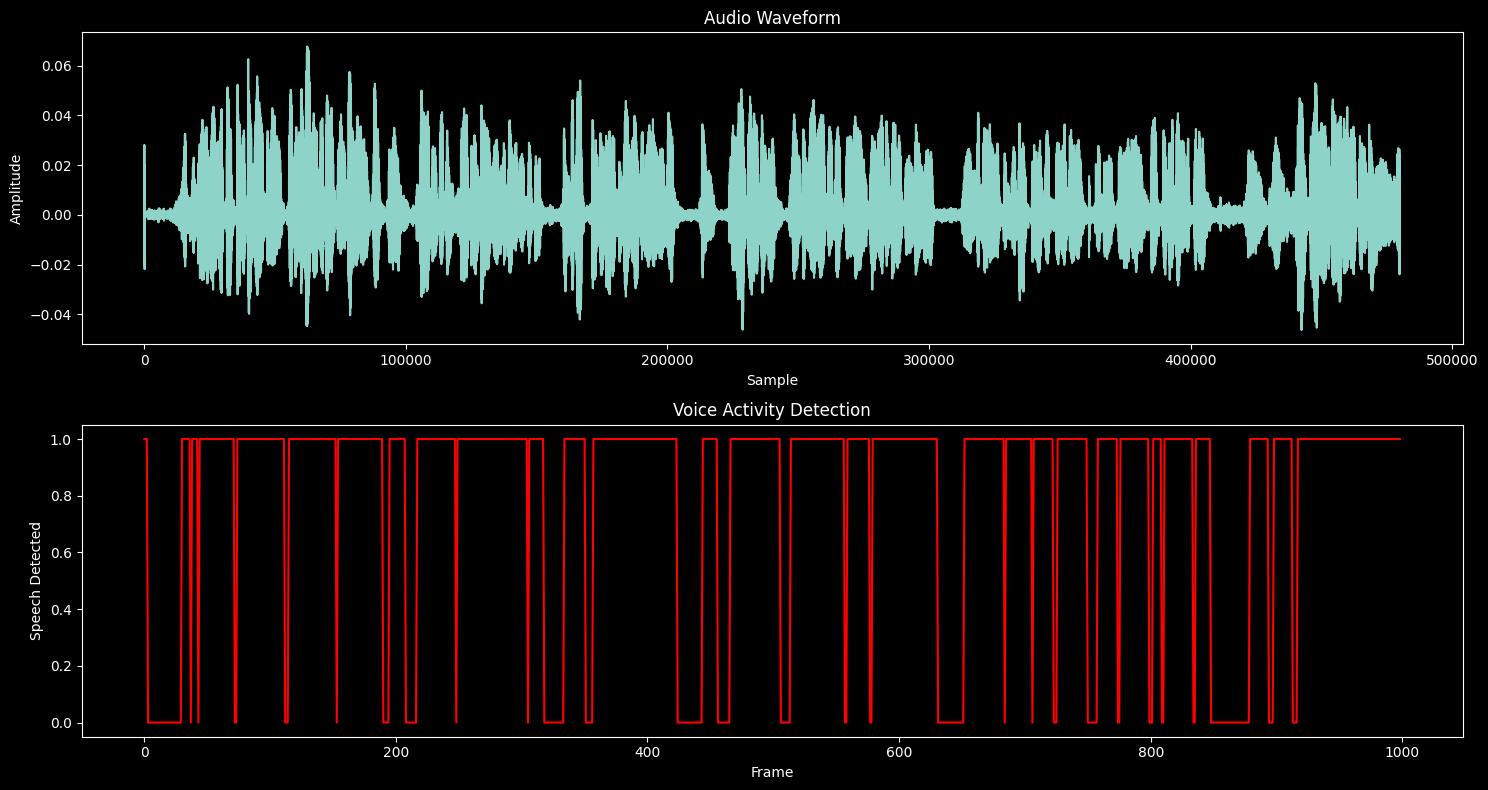

In [5]:
def test_vad(audio_data, sample_rate=sample_rate, frame_duration=30):
    """
    Test Voice Activity Detection on audio data.
    """
    frame_length = int(sample_rate * (frame_duration / 1000.0))
    frames = []
    speech_frames = []

    for i in range(0, len(audio_data) - frame_length, frame_length):
        frame = audio_data[i:i + frame_length]
        frame_bytes = (frame * 32767).astype(np.int16).tobytes()
        frames.append(frame)
        speech_frames.append(vad.is_speech(frame_bytes, sample_rate))

    return frames, speech_frames


# Test VAD
frames, speech_frames = test_vad(test_audio)

# Visualize VAD results
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(test_audio)
plt.title('Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(speech_frames, 'r')
plt.title('Voice Activity Detection')
plt.xlabel('Frame')
plt.ylabel('Speech Detected')

plt.tight_layout()
plt.show()

### Save recroded audio to file

In [9]:
def save_audio_to_file(audio_data: np.ndarray,
                       filename: str,
                       sample_rate: int = sample_rate) -> None:
    """
    Save audio data to a WAV file.
    
    Args:
        audio_data: Audio data as a NumPy array.
        filename: Name of the output WAV file.
        sample_rate: Sample rate of the audio data in Hz.
    """
    sf.write(filename, audio_data, sample_rate)


# Save the audio to a file
save_audio_to_file(test_audio, 'test_audio.wav')

### Audio helper methods

In [5]:
class AudioFormatError(Exception):
    """Custom exception for audio format-related errors."""
    pass


def validate_audio_data(audio_data: np.ndarray) -> None:
    """
    Validate the input audio data array.

    Parameters:
    - audio_data: NumPy array of audio samples

    Raises:
    - TypeError: If input is not a NumPy array
    - ValueError: If array is empty or contains invalid values
    """
    if not isinstance(audio_data, np.ndarray):
        raise TypeError("Audio data must be a NumPy array")

    if audio_data.size == 0:
        raise ValueError("Audio data array is empty")

    if not np.issubdtype(audio_data.dtype, np.number):
        raise ValueError("Audio data must contain numeric values")

    if np.any(np.abs(audio_data) > 1.0):
        warnings.warn(
            "Audio data contains values outside the normalized range [-1, 1]")


def get_supported_formats() -> list:
    """
    Return a list of supported audio formats.

    Returns:
    - List of supported format strings
    """
    return ['mp3', 'wav', 'ogg', 'flac']


def file_to_audio_data(audio_bytes: Union[io.BytesIO, bytes, str],
                       format: Optional[str] = 'mp3',
                       normalize: bool = True) -> Tuple[np.ndarray, dict]:
    """
    Convert audio file data back to a NumPy array.

    Parameters:
    - audio_bytes: Either a BytesIO object, bytes object, or path to audio file
    - format: Audio format (optional, required if input is BytesIO or bytes)
    - normalize: Whether to normalize the output to [-1, 1] range (default: True)

    Returns:
    - Tuple containing:
        - NumPy array of audio samples
        - Dictionary with audio metadata (sample rate, channels, etc.)

    Raises:
    - ValueError: If input format is not specified for BytesIO/bytes input
    - AudioFormatError: If audio format is not supported
    """
    try:
        # Handle different input types
        if isinstance(audio_bytes, str):
            # Input is a file path
            audio_segment = AudioSegment.from_file(audio_bytes)
        elif isinstance(audio_bytes, (io.BytesIO, bytes)):
            # Input is bytes or BytesIO
            if format is None:
                raise ValueError(
                    "Format must be specified when input is bytes or BytesIO")
            if format.lower() not in get_supported_formats():
                raise AudioFormatError(f"Unsupported format: {format}")

            if isinstance(audio_bytes, bytes):
                audio_bytes = io.BytesIO(audio_bytes)

            audio_bytes.seek(0)
            audio_segment = AudioSegment.from_file(audio_bytes, format=format)
        else:
            raise TypeError("Input must be BytesIO, bytes, or file path")

        # Get audio info
        info = {
            'sample_rate': audio_segment.frame_rate,
            'channels': audio_segment.channels,
            'sample_width': audio_segment.sample_width,
            'duration_seconds': len(audio_segment) / 1000
        }

        # Convert to numpy array
        samples = np.array(audio_segment.get_array_of_samples())

        # Handle multi-channel audio
        if audio_segment.channels > 1:
            samples = samples.reshape((-1, audio_segment.channels))

        # Convert to float and normalize
        dtype_info = np.iinfo(samples.dtype)
        samples = samples.astype(np.float32)

        if normalize:
            samples /= max(abs(dtype_info.min), dtype_info.max)

        return samples

    except Exception as e:
        # Re-raise known exceptions, wrap unknown ones
        if isinstance(e, (AudioFormatError, ValueError, TypeError)):
            raise
        raise RuntimeError(f"Error decoding audio data: {str(e)}") from e


def split_into_chunks(audio_data: np.ndarray,
                      chunk_size: int) -> List[np.ndarray]:
    """
    Split audio data into chunks with proper handling of remainder.

    Parameters:
    - audio_data: NumPy array of audio samples
    - chunk_size: Size of each chunk in samples

    Returns:
    - List of NumPy arrays, each representing a chunk of audio data
    """
    chunks = []
    for i in range(len(audio_data) // chunk_size):
        chunk = audio_data[i * chunk_size:(i + 1) * chunk_size]
        # Pad last chunk if necessary
        if len(chunk) < chunk_size:
            chunk = np.pad(chunk, (0, chunk_size - len(chunk)),
                           mode='constant')
        chunks.append(chunk)
    return chunks

### Detect VAD in human audio chunk wise

In [7]:
import os
import numpy as np
import webrtcvad
from typing import Tuple, List

# Explicitly set the TOKENIZERS_PARALLELISM environment variable
os.environ['TOKENIZERS_PARALLELISM'] = 'false'


def detect_vad(audio: np.ndarray,
               sample_rate: int = sample_rate,
               chunk_size_ms: int = 30,
               vad_aggressiveness: int = 3,
               min_speech_duration_ms: int = 300,
               min_silence_duration_ms: int = 300) -> List[Tuple[int, int]]:
    """
    Detect voice activity in audio using the WebRTC VAD algorithm.
    
    Args:
        audio: numpy array of audio samples
        sample_rate: sampling rate in Hz
        chunk_size_ms: size of each chunk in milliseconds
        vad_aggressiveness: VAD aggressiveness mode (0-3, 3 being the most aggressive)
        min_speech_duration_ms: minimum duration of speech to consider it valid
        min_silence_duration_ms: minimum silence duration to split segments
        
    Returns:
        List of tuples containing start and end sample indices of voice activity
    """
    # Convert ms to samples
    chunk_size = int(sample_rate * chunk_size_ms / 1000)
    min_speech_samples = int(sample_rate * min_speech_duration_ms / 1000)
    min_silence_samples = int(sample_rate * min_silence_duration_ms / 1000)

    # Initialize WebRTC VAD
    vad = webrtcvad.Vad(mode=vad_aggressiveness)

    # Ensure audio is 16-bit signed integer
    if audio.dtype != np.int16:
        audio = (audio * 32767).astype(np.int16)

    # Process audio chunk by chunk
    is_speech = []
    chunks = split_into_chunks(audio, chunk_size)
    for chunk in chunks:
        is_speech.append(vad.is_speech(chunk.tobytes(), sample_rate))

    # Convert boolean array to speech segments
    speech_segments = []
    in_speech = False
    start_idx = 0

    for i, speech in enumerate(is_speech):
        if speech and not in_speech:
            start_idx = i * chunk_size
            in_speech = True
        elif not speech and in_speech:
            # Check if speech duration is long enough
            if i * chunk_size - start_idx >= min_speech_samples:
                speech_segments.append((start_idx, i * chunk_size))
                in_speech = False

    # Handle the last segment
    if in_speech:
        speech_segments.append((start_idx, len(audio)))

    # Merge segments that are too close
    merged_segments = []
    if speech_segments:
        current_start, current_end = speech_segments[0]

        for start, end in speech_segments[1:]:
            if start - current_end < min_silence_samples:
                current_end = end
            else:
                merged_segments.append((current_start, current_end))
                current_start, current_end = start, end

        merged_segments.append((current_start, current_end))

    return merged_segments


def apply_vad_mask(audio: np.ndarray,
                   vad_segments: List[Tuple[int, int]]) -> np.ndarray:
    """
    Apply VAD mask to audio, zeroing out non-speech segments.
    
    Args:
        audio: numpy array of audio samples
        vad_segments: list of (start, end) tuples for speech segments
        
    Returns:
        Masked audio array with non-speech segments set to zero
    """
    masked_audio = np.zeros_like(audio)

    for start, end in vad_segments:
        masked_audio[start:end] = audio[start:end]

    return masked_audio

In [8]:
vad_segments = detect_vad(test_audio, sample_rate)

print("Doing something")

# Print speech segments
for start, end in vad_segments:
    print(
        f"Speech found from {start/sample_rate:.2f}s to {end/sample_rate:.2f}s"
    )

Doing something
Speech found from 0.00s to 0.30s
Speech found from 0.90s to 9.54s
Speech found from 10.02s to 12.72s
Speech found from 13.32s to 13.68s
Speech found from 13.98s to 18.93s
Speech found from 19.56s to 25.44s
Speech found from 26.37s to 30.00s


### See if cuda is available

In [6]:
print("Is Cuda available {}".format(torch.cuda.is_available()))

Is Cuda available False


### 3. Test Faster Whisper Transcription

In [ ]:
def test_transcription(audio_data, sample_rate=16000):
    """
    Test faster-whisper transcription.
    """
    # Initialize model
    model = WhisperModel(
        model_size_or_path='distil-large-v3',
        device="cuda" if torch.cuda.is_available() else "cpu",
        compute_type="float16" if torch.cuda.is_available() else "int8")

    # Transcribe
    segments, info = model.transcribe(audio_data, beam_size=5, language="en")

    # i want to print the progress of the transcription

    for segment in tqdm(segments, desc="Transcribing"):
        yield segment.text


# Test transcription
segments = list(test_transcription(test_audio))
print(f"Transcription segments: {segments}")

### Sentiment analysis

In [ ]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis",
                              framework="pt",
                              model="SamLowe/roberta-base-go_emotions",
                              device='mps')


def analyze_sentiment(text):
    results = sentiment_analysis(text)
    final_ = []
    for result in results:
        input_ = text[results.index(result)]
        final_.append({
            'input': input_,
            'label': result['label'],
            'score': result['score'],
            'with_sentiment': f"[{result['label']}]{input_}"
        })
    return final_


analyze_sentiment(segments)

### Realtime tts

In [6]:
from RealtimeTTS import CoquiEngine, TextToAudioStream # type: ignore
engine = CoquiEngine(
    voice="jenny",
    device='mps'
) # replace with your TTS engine
stream = TextToAudioStream(engine)

INFO:__main__:Stopped and closed all audio streams
INFO:root:Local XTTS Model: "v2.0.2" specified
INFO:root:Checking for models within application directory: "/Users/harshvardhangoswami/Projects/airley.ai/pilot/models/v2.0.2"
INFO:root:config.json exists in /Users/harshvardhangoswami/Projects/airley.ai/pilot/models/v2.0.2/config.json (no download).
INFO:root:model.pth exists in /Users/harshvardhangoswami/Projects/airley.ai/pilot/models/v2.0.2/model.pth (no download).
INFO:root:vocab.json exists in /Users/harshvardhangoswami/Projects/airley.ai/pilot/models/v2.0.2/vocab.json (no download).
INFO:root:speakers_xtts.pth exists in /Users/harshvardhangoswami/Projects/airley.ai/pilot/models/v2.0.2/speakers_xtts.pth (no download).


LOADING CONFIG JSON FROM /Users/harshvardhangoswami/Projects/airley.ai/pilot/models/v2.0.2/config.json


INFO:root:Coqui synthesis model ready
INFO:root:Initializing tokenizer nltk for language en
INFO:root:Initializing NLTK Tokenizer
INFO:root:loaded engine coqui


### New audio processor

In [2]:
import ollama
import webrtcvad
import threading
import time
import logging
import numpy as np
from queue import Queue
from faster_whisper import WhisperModel
import sounddevice as sd

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class AudioProcessor:
    def __init__(self, replier, silence_threshold_ms=500, vad_mode=3, batch_duration_ms=1000):
        """
        Initializes the audio processor with rolling transcription.

        Args:
            replier (callable): The function to call when there's a long enough pause.
            silence_threshold_ms (int): The pause length (in ms) to trigger a reply.
            vad_mode (int): Sensitivity of VAD (0 to 3). 0 is the most aggressive, 3 the least.
            batch_duration_ms (int): Duration of audio to batch transcribe while speaking.
        """
        logger.info(f"Initializing AudioProcessor with silence_threshold_ms={silence_threshold_ms}, vad_mode={vad_mode}, batch_duration_ms={batch_duration_ms}")
        
        self.vad = webrtcvad.Vad(vad_mode)
        self.transcription_model = WhisperModel(
            model_size_or_path='distil-large-v3',
            device="auto", 
            compute_type="int8",
            cpu_threads=8,
            num_workers=8
        )
        self.replier = replier
        self.silence_threshold = silence_threshold_ms / 1000
        self.batch_duration = batch_duration_ms / 1000
        self.audio_buffer = Queue()
        self.speech_buffer = bytearray()
        self.last_activity_time = time.time()
        self.last_transcription_time = time.time()
        self.temp_buffer = bytearray()
        self.frame_duration_ms = 30
        self.sample_rate = 16000
        self.frame_size = int(self.sample_rate * self.frame_duration_ms / 1000 * 2)
        self.transcribed_text = ""
        self.is_speaking = False
        self.consecutive_silence_frames = 0
        self.min_speech_frames = 10
        self.padding_duration_ms = 1000
        self.rolling_audio_buffer = bytearray()
        self.echo_stream = stream
        self.echo_stream.stop()
        
        # Start background thread for processing
        self.processing_thread = threading.Thread(target=self._process_audio_stream, daemon=True)
        self.processing_thread.start()

        # Start audio streams
        self.stream = sd.InputStream(
            samplerate=self.sample_rate,
            channels=1,
            dtype=np.int16,
            blocksize=int(self.sample_rate * self.frame_duration_ms / 1000),
            callback=self._audio_callback,
            device=None
        )
        self.stream.start()

    def _audio_callback(self, indata, frames, time, status):
        """Callback function for audio stream"""
        if status:
            logger.warning(f"Stream callback status: {status}")
        audio_chunk = indata.flatten()
        self.receive_audio_chunk(audio_chunk)

    def receive_audio_chunk(self, audio_chunk: np.ndarray):
        self.echo_stream.stop()
        """Receives an audio chunk from the microphone."""
        self.audio_buffer.put(audio_chunk)

    def _process_audio_stream(self):
        """Continuously processes audio chunks from the buffer."""
        logger.info("Starting audio stream processing thread")
        chunk_size = int(self.sample_rate * self.frame_duration_ms / 1000)
        
        while True:
            try:
                audio_chunks = []
                total_samples = 0
                
                while total_samples < chunk_size:
                    if not self.audio_buffer.empty():
                        chunk = self.audio_buffer.get_nowait()
                        audio_chunks.append(chunk)
                        total_samples += len(chunk)
                    else:
                        time.sleep(0.001)
                        break
                
                if audio_chunks:
                    combined_chunk = np.concatenate(audio_chunks)
                    self._process_audio_chunk(combined_chunk)
                
            except Exception as e:
                logger.error(f"Error in audio stream processing: {e}")
                time.sleep(0.1)

    def _process_audio_chunk(self, audio_chunk: np.ndarray):
        """
        Processes a single audio chunk, handling VAD and rolling transcription.
        """
        audio_bytes = audio_chunk.tobytes()
        self.temp_buffer.extend(audio_bytes)
        
        while len(self.temp_buffer) >= self.frame_size:
            frame_bytes = bytes(self.temp_buffer[:self.frame_size])
            self.temp_buffer = self.temp_buffer[self.frame_size:]

            try:
                is_speech = self.vad.is_speech(frame_bytes, sample_rate=self.sample_rate)
            except Exception as e:
                logger.warning(f"VAD detection failed, falling back to energy-based: {str(e)}")
                is_speech = not self._is_silence(audio_chunk)

            if is_speech:
                # self.echo_stream.stop();
                self.consecutive_silence_frames = 0
                self.speech_buffer.extend(frame_bytes)
                self.rolling_audio_buffer.extend(frame_bytes)
                self.is_speaking = True
                self.last_activity_time = time.time()
                
                rolling_buffer_duration = len(self.rolling_audio_buffer) / (self.sample_rate * 2)
                time_since_last_transcription = time.time() - self.last_transcription_time
                
                if rolling_buffer_duration >= self.batch_duration and time_since_last_transcription >= self.batch_duration:
                    self._rolling_transcribe()
            else:
                self.consecutive_silence_frames += 1
                silence_duration = self.consecutive_silence_frames * (self.frame_duration_ms / 1000)
                
                if (silence_duration >= self.silence_threshold and 
                    self.is_speaking and 
                    len(self.speech_buffer) > self.frame_size * self.min_speech_frames):
                    
                    self._final_transcribe()
                    self.speech_buffer = bytearray()
                    self.rolling_audio_buffer = bytearray()
                    self.is_speaking = False
                    self.consecutive_silence_frames = 0
                    final_text = self.transcribed_text
                    self.transcribed_text = ""
                    self.replier(final_text)
                elif not self.is_speaking:
                    self.speech_buffer = bytearray()
                    self.rolling_audio_buffer = bytearray()

    def _is_silence(self, audio_chunk: np.ndarray) -> bool:
        """Enhanced silence detection with multiple criteria."""
        if audio_chunk.size == 0:
            return True

        rms = np.sqrt(np.mean(np.square(audio_chunk)))
        peak = np.max(np.abs(audio_chunk))
        zero_crossings = np.sum(np.abs(np.diff(np.signbit(audio_chunk))))

        return (rms < self.silence_threshold
                and peak < self.silence_threshold * 2
                and zero_crossings < len(audio_chunk) * 0.1)

    def _rolling_transcribe(self):
        """Transcribes the current batch of speech while user is still talking."""
        try:
            full_audio = np.frombuffer(self.rolling_audio_buffer, dtype=np.int16)
            
            segments, _ = self.transcription_model.transcribe(
                full_audio,
                word_timestamps=True,
                condition_on_previous_text=True,
                initial_prompt=self.transcribed_text,
                language="en",
                beam_size=5
            )
            
            batch_text = " ".join(segment.text for segment in segments)
            
            if not self.transcribed_text:
                self.transcribed_text = batch_text
            else:
                last_words = self.transcribed_text.split()[-3:]
                new_words = batch_text.split()
                
                for i in range(len(new_words)):
                    if " ".join(new_words[i:i+len(last_words)]) == " ".join(last_words):
                        self.transcribed_text += " " + " ".join(new_words[i+len(last_words):])
                        break
                else:
                    self.transcribed_text += " " + batch_text
            
            logger.info(f"Rolling transcription updated: {self.transcribed_text}")
            
            keep_duration = 0.5
            keep_samples = int(keep_duration * self.sample_rate * 2)
            if len(self.rolling_audio_buffer) > keep_samples:
                self.rolling_audio_buffer = self.rolling_audio_buffer[-keep_samples:]
            
            self.last_transcription_time = time.time()
            
        except Exception as e:
            logger.error(f"Rolling transcription error: {e}")

    def _final_transcribe(self):
        """Transcribes any remaining audio when speech ends."""
        if len(self.speech_buffer) > 0:
            try:
                full_audio = np.frombuffer(self.speech_buffer, dtype=np.int16)

                if self.padding_duration_ms > 0:
                    padding_samples = int(self.sample_rate * self.padding_duration_ms / 1000)
                    full_audio = np.pad(full_audio, (padding_samples, padding_samples))

                segments, _ = self.transcription_model.transcribe(
                    full_audio,
                    word_timestamps=True,
                    condition_on_previous_text=True,
                    initial_prompt=self.transcribed_text,
                    language="en",
                    beam_size=5
                )
                
                final_text = " ".join(segment.text for segment in segments)
                
                if not self.transcribed_text:
                    self.transcribed_text = final_text
                else:
                    last_words = self.transcribed_text.split()[-3:]
                    new_words = final_text.split()
                    
                    for i in range(len(new_words)):
                        if " ".join(new_words[i:i+len(last_words)]) == " ".join(last_words):
                            self.transcribed_text += " " + " ".join(new_words[i+len(last_words):])
                            break
                    else:
                        self.transcribed_text += " " + final_text
                
                logger.info(f"Final transcription: {self.transcribed_text}")
                
            except Exception as e:
                logger.error(f"Final transcription error: {e}")

    def stop(self):
        """Stops all streams and cleans up resources."""
        if hasattr(self, 'stream'):
            self.stream.stop()
            self.stream.close()
        if hasattr(self, 'echo_stream'):
            self.echo_stream.stop()
            self.echo_stream.close()
        logger.info("Stopped and closed all audio streams")

    def __del__(self):
        """Cleanup when object is destroyed"""
        self.stop()

def test_real_time_processor():
    """Tests the AudioProcessor with real-time microphone input"""
    history = []
    prompt = """You are a friendly conversational AI assistant. When you receive a transcript of user speech:

1. First clean up any mistakes like:
   - Repeated words or phrases
   - Incomplete sentences
   - Speech recognition errors
   
2. Then respond naturally like a friend would:
   - Keep responses concise but warm and engaging
   - Match the user's tone and energy
   - Use casual, conversational language
   - Feel free to ask follow-up questions to keep the chat going

3. If you truly cannot understand the message after cleanup:
   - Politely say "I didn't quite catch that. Could you please try saying that again?"
   - Optionally suggest what specific part was unclear

Remember to maintain a natural flow of conversation while being helpful and friendly!"""
    
    def llm_chat(history):
        response = ollama.chat(
            model="airley-ai:latest",
            messages=[
                {"role": "system", "content": prompt},
                *history
            ],
            stream=True
        )

        for chunk in response:
            if 'message' in chunk and 'content' in chunk['message']:
                yield chunk['message']['content']

    def replier(message: str):
        print(f"We got a message: {message}")
        history.append({
            "role": "user",
            "content": message
        })

        llm_stream = llm_chat(history)

        processor.echo_stream.feed(llm_stream)
        processor.echo_stream.play_async(
            on_audio_chunk=lambda chunk: print(f"We got a chunk: {chunk}")
        )
        while processor.echo_stream.is_playing():
            time.sleep(0.1)

        final_response = ""
        for chunk in llm_stream:
            print(f"We got a chunk: {chunk}")
            final_response += chunk

        history.append({
            "role": "assistant",
            "content": final_response
        })

        logger.info(f"Assistant response: {final_response}")

    processor = AudioProcessor(replier=replier, silence_threshold_ms=700)
    
    try:
        logger.info("Recording started. Press Ctrl+C to stop...")
        while True:
            time.sleep(0.1)
    except KeyboardInterrupt:
        logger.info("Recording stopped by user")
        processor.stop()

if __name__ == "__main__":
    test_real_time_processor()

INFO:__main__:Initializing AudioProcessor with silence_threshold_ms=700, vad_mode=3, batch_duration_ms=1000
INFO:__main__:Starting audio stream processing thread
INFO:__main__:Recording started. Press Ctrl+C to stop...
INFO:faster_whisper:Processing audio with duration 00:02.750
INFO:__main__:Final transcription:  Fuck to human.
INFO:root:stream start


We got a message:  Fuck to human.


INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:root:stream stop
INFO:root:stream start


We got a chunk: I
We got a chunk:  didn
We got a chunk: 't
We got a chunk:  quite
We got a chunk:  catch
We got a chunk:  that
We got a chunk: .


INFO:root:stream stop
INFO:root:stream start


We got a chunk:  Could
We got a chunk:  you
We got a chunk:  please
We got a chunk:  try
We got a chunk:  saying
We got a chunk:  that
We got a chunk:  again
We got a chunk: ?
We got a chunk:  I
We got a chunk: 'm
We got a chunk:  here
We got a chunk:  to
We got a chunk:  help
We got a chunk: ,


INFO:root:stream stop
INFO:root:stream start


We got a chunk:  but
We got a chunk:  I
We got a chunk:  want
We got a chunk:  to
We got a chunk:  make
We got a chunk:  sure
We got a chunk:  we


INFO:root:stream stop
INFO:root:stream start


We got a chunk: 're
We got a chunk:  on
We got a chunk:  the
We got a chunk:  same
We got a chunk:  page
We got a chunk: .
We got a chunk:  What


INFO:root:stream stop
INFO:root:stream start
INFO:__main__:Assistant response: I didn't quite catch that. Could you please try saying that again? I'm here to help, but I want to make sure we're on the same page. What's on your mind?


We got a chunk: 's
We got a chunk:  on
We got a chunk:  your
We got a chunk:  mind
We got a chunk: ?
We got a chunk: 


INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:stream stop
INFO:root:stream start
INFO:root:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime
import json
from pathlib import Path
import pandas as pd


class AudioProcessorTester:

    def __init__(self,
                 save_results: bool = True,
                 output_dir: str = "test_results"):
        """
        Initialize the tester with configuration options.

        Parameters:
        - save_results: Whether to save test results to files
        - output_dir: Directory to save test results
        """
        self.save_results = save_results
        self.output_dir = Path(output_dir)
        if save_results:
            self.output_dir.mkdir(exist_ok=True)

        self.test_metrics = {
            'total_chunks': 0,
            'processed_chunks': 0,
            'detected_utterances': 0,
            'processing_times': [],
            'chunk_sizes': [],
            'transcription_lengths': [],
            'language_probabilities': []
        }

    def test_complete_pipeline(
            self,
            audio_data: np.ndarray,
            chunk_size_ms: int = 30,
            sample_rate: int = 16000,
            processor_kwargs: Optional[Dict] = None
    ) -> Tuple[List[Dict], Dict]:
        """
        Test the complete audio processing pipeline with detailed metrics and validation.

        Parameters:
        - audio_data: Input audio data as numpy array
        - chunk_size_ms: Size of each chunk in milliseconds
        - sample_rate: Audio sample rate
        - processor_kwargs: Additional kwargs for AudioProcessor initialization

        Returns:
        - Tuple of (results, metrics)
        """
        try:
            # Initialize processor with custom parameters
            processor_kwargs = processor_kwargs or {}
            processor = AudioProcessor(sample_rate=sample_rate,
                                       chunk_duration_ms=chunk_size_ms,
                                       **processor_kwargs)

            # Validate input audio
            self._validate_audio_data(audio_data, sample_rate)

            # Split audio into chunks
            chunk_size = int(sample_rate * (chunk_size_ms / 1000.0))
            chunks = split_into_chunks(audio_data, chunk_size)

            # Process chunks with progress bar
            results = []
            timings = []

            with tqdm(total=len(chunks),
                      desc="Processing audio chunks") as pbar:
                for i, chunk in enumerate(chunks):
                    # Time the processing
                    start_time = datetime.now()

                    # Create event data
                    event_data = self._create_event_data(chunk, i)

                    # Process chunk
                    result = processor.process_audio_chunk(event_data)

                    # Record timing
                    processing_time = (datetime.now() -
                                       start_time).total_seconds() * 1000
                    timings.append(processing_time)

                    # Update metrics
                    self._update_metrics(chunk, result, processing_time)

                    # Store result
                    if result:
                        results.append(
                            self._enrich_result(result, i, processing_time))

                    pbar.update(1)

            # Calculate final metrics
            final_metrics = self._calculate_final_metrics()

            # Save results if enabled
            if self.save_results:
                self._save_test_results(results, final_metrics)
                self._generate_visualizations(results, timings)

            return results, final_metrics

        except Exception as e:
            raise RuntimeError(f"Pipeline test failed: {str(e)}")

    def _validate_audio_data(self, audio_data: np.ndarray, sample_rate: int):
        """Validate input audio data."""
        if not isinstance(audio_data, np.ndarray):
            raise ValueError("Audio data must be a NumPy array")

        if audio_data.size == 0:
            raise ValueError("Audio data is empty")

        expected_duration = len(audio_data) / sample_rate
        if expected_duration < 0.1:  # Arbitrary minimum duration
            raise ValueError(
                f"Audio too short: {expected_duration:.2f} seconds")

    def _create_event_data(self, chunk: np.ndarray, index: int) -> Dict:
        """Create event data for chunk processing."""
        return {
            "event_id": f"event_{index}",
            "type": "input_audio_buffer.append",
            "timestamp": datetime.now().isoformat(),
            "audio": chunk,
            "chunk_index": index
        }

    def _update_metrics(self, chunk: np.ndarray, result: Optional[Dict],
                        processing_time: float):
        """Update test metrics with chunk processing results."""
        self.test_metrics['total_chunks'] += 1
        self.test_metrics['processed_chunks'] += 1 if result else 0
        self.test_metrics['detected_utterances'] += 1 if result and result.get(
            'should_respond') else 0
        self.test_metrics['processing_times'].append(processing_time)
        self.test_metrics['chunk_sizes'].append(len(chunk))

        if result:
            self.test_metrics['transcription_lengths'].append(
                len(result['transcript'].split()))
            self.test_metrics['language_probabilities'].append(
                result['language_probability'])

    def _enrich_result(self, result: Dict, chunk_index: int,
                       processing_time: float) -> Dict:
        """Enrich result with additional metadata."""
        return {
            **result, "chunk_index": chunk_index,
            "processing_time_ms": processing_time,
            "timestamp": datetime.now().isoformat()
        }

    def _calculate_final_metrics(self) -> Dict:
        """Calculate final metrics from collected data."""
        processing_times = np.array(self.test_metrics['processing_times'])

        metrics = {
            "total_chunks_processed":
            self.test_metrics['total_chunks'],
            "utterances_detected":
            self.test_metrics['detected_utterances'],
            "detection_rate":
            self.test_metrics['detected_utterances'] /
            self.test_metrics['total_chunks'],
            "processing_time_stats": {
                "mean_ms": np.mean(processing_times),
                "std_ms": np.std(processing_times),
                "min_ms": np.min(processing_times),
                "max_ms": np.max(processing_times),
                "p95_ms": np.percentile(processing_times, 95)
            }
        }

        if self.test_metrics['transcription_lengths']:
            metrics["transcription_stats"] = {
                "mean_words":
                np.mean(self.test_metrics['transcription_lengths']),
                "max_words":
                np.max(self.test_metrics['transcription_lengths']),
                "total_words": sum(self.test_metrics['transcription_lengths'])
            }

        return metrics

    def _save_test_results(self, results: List[Dict], metrics: Dict):
        """Save test results and metrics to files."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save results
        results_file = self.output_dir / f"test_results_{timestamp}.json"
        with open(results_file, 'w') as f:
            json.dump({"results": results, "metrics": metrics}, f, indent=2)

        # Save metrics to CSV for easy analysis
        metrics_df = pd.DataFrame(results)
        metrics_file = self.output_dir / f"test_metrics_{timestamp}.csv"
        metrics_df.to_csv(metrics_file, index=False)

    def _generate_visualizations(self, results: List[Dict],
                                 timings: List[float]):
        """Generate visualizations of test results."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Processing times
        axes[0, 0].plot(timings)
        axes[0, 0].set_title('Processing Times per Chunk')
        axes[0, 0].set_xlabel('Chunk Index')
        axes[0, 0].set_ylabel('Processing Time (ms)')

        # Language probabilities
        if results:
            probs = [r['language_probability'] for r in results]
            axes[0, 1].hist(probs, bins=20)
            axes[0, 1].set_title('Language Detection Probabilities')
            axes[0, 1].set_xlabel('Probability')
            axes[0, 1].set_ylabel('Count')

        # Transcription lengths
        if results:
            lengths = [len(r['transcript'].split()) for r in results]
            axes[1, 0].hist(lengths, bins=20)
            axes[1, 0].set_title('Transcription Lengths')
            axes[1, 0].set_xlabel('Words')
            axes[1, 0].set_ylabel('Count')

        # Response timeline
        if results:
            chunk_indices = [r['chunk_index'] for r in results]
            responses = [1 if r['should_respond'] else 0 for r in results]
            axes[1, 1].scatter(chunk_indices, responses)
            axes[1, 1].set_title('Response Timeline')
            axes[1, 1].set_xlabel('Chunk Index')
            axes[1, 1].set_ylabel('Should Respond')

        plt.tight_layout()
        plot_file = self.output_dir / f"test_visualizations_{timestamp}.png"
        plt.savefig(plot_file)
        plt.close()


def test_pipeline(audio_data: np.ndarray, **kwargs):
    """
    Convenience function to test the pipeline with default settings.
    """
    tester = AudioProcessorTester()
    return tester.test_complete_pipeline(audio_data, **kwargs)


# Example usage
if __name__ == "__main__":
    # Run pipeline test
    results, metrics = test_pipeline(test_audio, chunk_size_ms=40)

    # Print results
    print("\nTest Results Summary:")
    print(f"Total chunks processed: {metrics['total_chunks_processed']}")
    print(f"Utterances detected: {metrics['utterances_detected']}")
    print(f"Detection rate: {metrics['detection_rate']:.2%}")
    print("\nProcessing Time Statistics:")
    for key, value in metrics['processing_time_stats'].items():
        print(f"{key}: {value:.2f}ms")

    # Individual results are available in the results list
    for result in results:
        print(f"\nTranscript: {result['transcript']}")
        print(
            f"Language: {result['language']} (prob: {result['language_probability']:.2f})"
        )
        print(f"Processing time: {result['processing_time_ms']:.2f}ms")

## LLM BASED DECISION WHETHER TO REPLY OR NOT?

In [ ]:
import ollama  # Assuming the SDK is named 'ollama'


def is_reply_worthy(input_text: str, api_key: str) -> bool:
    """
    Determine if the input text is reply-worthy using Ollama's generate method.

    Parameters:
    - input_text: The input text to evaluate.
    - api_key: The API key for accessing Ollama's services.

    Returns:
    - bool: True if the input is reply-worthy, False otherwise.
    """
    # System prompt defining the task
    system_prompt = """
    Determine if the following input is worthy of a reply. Respond with 'Yes' if it is, and 'No' if it is not.
    Input:
    """

    # Combine the system prompt with the input text
    full_prompt = system_prompt + input_text

    try:
        # Generate the response
        response = ollama.generate(model='incept5/llama3.1-claude:latest',
                                   prompt=full_prompt)

        # Extract the generated text
        generated_text = response['response']

        # Determine if the input is reply-worthy
        if generated_text.lower() == 'yes':
            return True
        else:
            return False

    except Exception as e:
        print(f"Error generating response: {str(e)}")
        return False


# Example usage
input_text = "Hello, how are you?"
is_worthy = is_reply_worthy(input_text, api_key)
print(f"Is the input reply-worthy? {is_worthy}")

In [ ]:
async def simulate_websocket_stream(audio_data, chunk_size_ms=30):
    """
    Simulate streaming audio over WebSocket.
    """
    chunk_size = int(16000 * (chunk_size_ms / 1000.0))
    chunks = split_into_chunks(audio_data, chunk_size)

    processor = AudioProcessor()

    class MockWebSocket:
        async def send(self, message):
            print(f"Received response: {message}")

    mock_ws = MockWebSocket()

    for i, chunk in enumerate(chunks):
        event_data = {
            "event_id": f"event_{i}",
            "type": "input_audio_buffer.append",
            "audio": chunk
        }

        await processor.process_audio_chunk(event_data)
        await asyncio.sleep(chunk_size_ms / 1000.0)  # Simulate real-time

# Test WebSocket simulation
await simulate_websocket_stream(test_audio)

## 6. Performance Metrics

In [ ]:
def measure_performance(audio_data, num_runs=5):
    """
    Measure performance metrics of the system.
    """
    processor = AudioProcessor()

    timings = {'vad': [], 'transcription': [], 'total': []}

    for _ in range(num_runs):
        start_total = time.time()

        # Test VAD
        start = time.time()
        frames, speech_frames = test_vad(audio_data)
        timings['vad'].append(time.time() - start)

        # Test transcription
        start = time.time()
        segments = test_transcription(audio_data)
        for segment in segments:
            pass
        timings['transcription'].append(time.time() - start)

        timings['total'].append(time.time() - start_total)

    print("Performance Metrics (averaged over {num_runs} runs):")
    for key, values in timings.items():
        avg_time = sum(values) / len(values)
        print(f"{key.capitalize()} processing time: {avg_time:.3f}s")

    # Plot the results as a stackplot
    runs = list(range(1, num_runs + 1))
    plt.figure(figsize=(10, 6))
    plt.stackplot(runs,
                  timings['vad'],
                  timings['transcription'],
                  timings['total'],
                  labels=['VAD', 'Transcription', 'Total'])

    plt.xlabel('Run Number')
    plt.ylabel('Processing Time (s)')
    plt.title('Cumulative Performance Metrics Over Multiple Runs')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


# Measure performance
measure_performance(test_audio)